In [1]:
import polars as pl
import seaborn as sns
from analysis import fetch_cases_from_db
import matplotlib.pyplot as plt
from currency_converter import CurrencyConverter

converter = CurrencyConverter()

sns.set_theme(rc={'figure.figsize':(12,8)})


In [28]:
table = fetch_cases_from_db()
table.head(5)

2024-03-25 10:23:16 INFO     Connecting to sql database
2024-03-25 10:23:24 INFO     Connected to sql database


codesolution,coderex,gainfinancier,codegainmonnaie,textgainmonnaie,coutfinancier,codecoutmonnaie,textcoutmonnaie,codeunitcout,textunitcoutenergie,gainenergie,codeunitenergie,textunitenergie,codeperiodeenergie,textperiodeenergie,codepublic,textpublic,codeTechno1,texttechno1,codeTechno2,texttechno2,codeTechno3,texttechno3,codetravaux,texttravaux,codereseau,textreseau,codepays,textpays,coderegion,textregion,ville,codesecteur,textsecteur
i64,i64,f64,i64,str,f64,i64,str,i64,str,f64,i64,str,i64,str,i64,str,i64,str,i64,str,i64,str,i64,str,i64,str,i64,str,i64,str,str,i64,str
1141,443,444.0,9,"""FRF""",200.0,9,"""FRF""",1,null,1640.0,5,"""kWh""",1,null,3,"""Privé""",14,"""Froid""",8,"""Eclairage""",1,null,3,"""Rénovation/ret…",1,"""-N/A-""",2,"""France""",2,"""National""",null,55,"""Grandes et Moy…"
241,345,null,1,null,null,null,null,null,null,null,1,null,1,null,3,"""Privé""",15,"""Moteur""",1,null,1,null,3,"""Rénovation/ret…",1,"""-N/A-""",2,"""France""",2,"""National""",null,3,"""Bois"""
254,498,null,1,null,null,null,null,null,null,null,1,null,1,null,3,"""Privé""",9,"""Enveloppe""",12,"""Chaudière""",1,null,3,"""Rénovation/ret…",1,"""-N/A-""",2,"""France""",2,"""National""",null,57,"""Résidentiel"""
557,498,null,1,null,null,null,null,null,null,null,1,null,1,null,3,"""Privé""",9,"""Enveloppe""",12,"""Chaudière""",1,null,3,"""Rénovation/ret…",1,"""-N/A-""",2,"""France""",2,"""National""",null,57,"""Résidentiel"""
901,2053,null,1,null,null,null,null,null,null,null,1,null,1,null,3,"""Privé""",3,"""Gestion des én…",7,"""CVC""",1,null,3,"""Rénovation/ret…",1,"""-N/A-""",2,"""France""",2,"""National""",null,51,"""Bureaux"""


/home/magic/.local/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


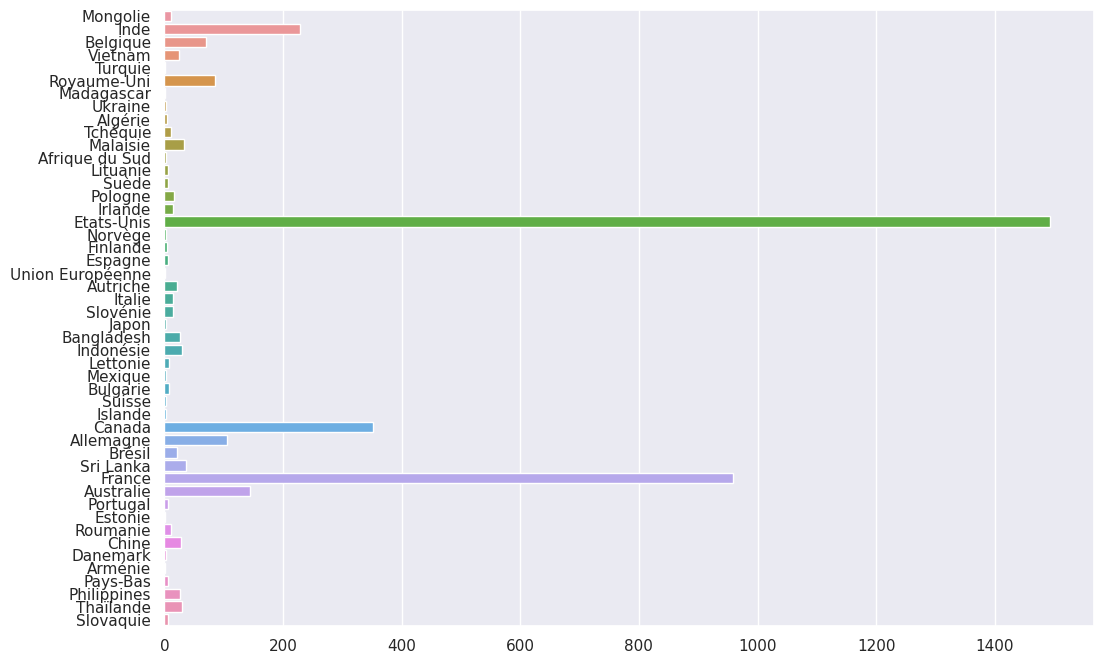

In [3]:
t = table["textpays"].value_counts().to_dict()
sns.barplot(y=t["textpays"].to_list(), x=t["count"].to_list(), orient="h")
plt.show()

In [4]:
def convert(x, from_currency, to_currency):
    # currencies last updated on 24-03-24
    if x is None or from_currency is None or to_currency is None:
        return x
    if from_currency == "FRF":
        rate = {"EUR": 0.15247,
                "USD": 0.16477}
        if to_currency not in rate.keys():
            raise KeyError(f"Currency not supported: {to_currency}")
        return x * rate[to_currency]
    if from_currency == "LACS":
        rate = {"EUR": 0.01100,
                "USD": 0.01190}
        if to_currency not in rate.keys():
            raise KeyError(f"Currency not supported: {to_currency}")
        return x * rate[to_currency]
    else:
        return converter.convert(x, from_currency, to_currency)

table = table.with_columns(pl.struct(["gainfinancier", "textgainmonnaie"]).map_elements(lambda x: convert(x["gainfinancier"], x["textgainmonnaie"], "EUR")).alias("gainfinancierEUR"))
table = table.with_columns(pl.struct(["coutfinancier", "textgainmonnaie"]).map_elements(lambda x: convert(x["coutfinancier"], x["textgainmonnaie"], "EUR")).alias("coutfinancierEUR"))

/home/magic/.local/lib/python3.11/site-packages/seaborn/regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/home/magic/.local/lib/python3.11/site-packages/seaborn/regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/home/magic/.local/lib/python3.11/site-packages/seaborn/regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/home/magic/.local/lib/python3.11/site-packages/seaborn/regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)
/home/magic/.local/lib/python3.11/site-packages/seaborn/regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


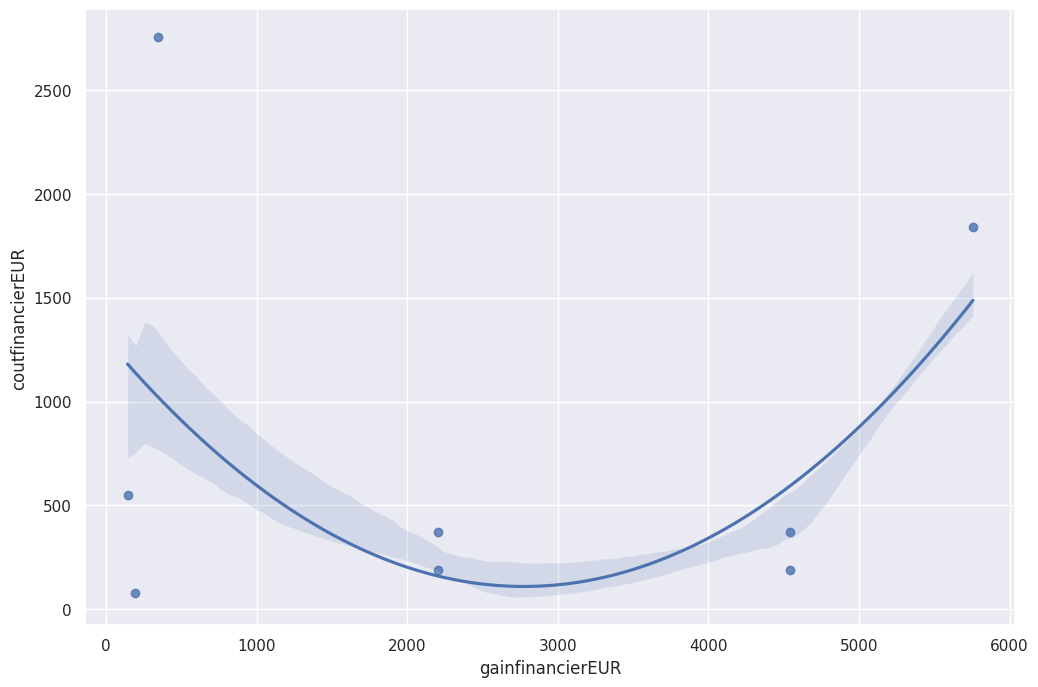

In [16]:
tbl = table.filter(pl.col("codesolution") == 334)
ax = sns.regplot(tbl, x="gainfinancierEUR", y="coutfinancierEUR", order=2, ci=25)
ax.set(xlabel='gainfinancierEUR', ylabel='coutfinancierEUR')
plt.show()

In [6]:
# "gainfinancierEUR", "coutfinancierEUR", 
import torch
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("distiluse-base-multilingual-cased-v1")
dimensions = table[["textpays", "textregion", "textpublic", "textsecteur", "texttravaux", "texttechno1", "texttechno2", "texttechno3", "textreseau"]].fill_null("")
display(dimensions.head())
sentences = ['. '.join(l) for l in dimensions.to_numpy()]
print(sentences[0])
embeddings = model.encode(sentences, convert_to_tensor=True)
print(embeddings.shape)

2024-03-25 00:18:08 INFO     Load pretrained SentenceTransformer: distiluse-base-multilingual-cased-v1


/home/magic/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/magic/.local/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


2024-03-25 00:18:11 INFO     Use pytorch device_name: cpu


textpays,textregion,textpublic,textsecteur,texttravaux,texttechno1,texttechno2,texttechno3,textreseau
str,str,str,str,str,str,str,str,str
"""France""","""National""","""Privé""","""Elevage""","""Neuf/extension…","""Séchage""","""""","""""","""-N/A-"""
"""France""","""National""","""Privé""","""Grandes et Moy…","""Rénovation/ret…","""Froid""","""Eclairage""","""""","""-N/A-"""
"""France""","""National""","""Privé""","""Grandes et Moy…","""Rénovation/ret…","""Froid""","""Eclairage""","""""","""-N/A-"""
"""France""","""National""","""Privé""","""Grandes et Moy…","""Rénovation/ret…","""Froid""","""Eclairage""","""""","""-N/A-"""
"""France""","""National""","""Privé""","""Résidentiel""","""Rénovation/ret…","""Enveloppe""","""Chaudière""","""""","""-N/A-"""


Batches:   0%|          | 0/130 [00:00<?, ?it/s]

torch.Size([4130, 512])


In [39]:
from sentence_transformers import util

query_sentence = "Pays. National. Privé. Elevage"
query_embedding = model.encode(query_sentence, convert_to_tensor=True)

print(query_embedding.shape)
print(embeddings.shape)

cos_scores = util.cos_sim(query_embedding, embeddings)[0]
print(cos_scores)
top_k = torch.topk(cos_scores, k=5)
for score, idx in zip(top_k[0], top_k[1]):
    print(score, idx)
    print(sentences[idx])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([512])
torch.Size([4130, 512])
tensor([0.6257, 0.4716, 0.4716,  ..., 0.2019, 0.3370, 0.3276])
tensor(0.7109) tensor(142)
France. National. Privé. Elevage. . Procédés. . . -N/A-
tensor(0.7109) tensor(2015)
France. National. Privé. Elevage. . Procédés. . . -N/A-
tensor(0.7109) tensor(2016)
France. National. Privé. Elevage. . Procédés. . . -N/A-
tensor(0.6857) tensor(2014)
France. National. Privé. Elevage. . Chaudière. Biomasse. . -N/A-
tensor(0.6779) tensor(3232)
France. National. Privé. Lait. . Froid. . . -N/A-


In [27]:
table[["codesolution", "coderex"]].unique()["codesolution"].value_counts().describe()

statistic,codesolution,count
str,f64,f64
"""count""",635.0,635.0
"""null_count""",0.0,0.0
"""mean""",660.751181,6.122835
"""std""",429.702969,12.872612
"""min""",1.0,1.0
"""25%""",270.0,1.0
"""50%""",725.0,2.0
"""75%""",986.0,6.0
"""max""",1632.0,185.0


In [52]:
import numpy as np
indexes = np.argwhere(table["codesolution"] == 218).ravel()
indexes.tolist()

[1305, 3329]

(4130, 9)